In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os

Mounted at /content/drive


In [ ]:
BASE_PATH = '/content/drive/MyDrive/LEVIR-CD'
TRAIN_PATH = os.path.join(BASE_PATH, 'Train')
VAL_PATH = os.path.join(BASE_PATH, 'Val')
TEST_PATH = os.path.join(BASE_PATH, 'Test')


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
TRAIN_A_PATH = os.path.join(TRAIN_PATH, 'A')
TRAIN_B_PATH = os.path.join(TRAIN_PATH, 'B')
TRAIN_LABEL_PATH = os.path.join(TRAIN_PATH, 'label')

VAL_A_PATH = os.path.join(VAL_PATH, 'A')
VAL_B_PATH = os.path.join(VAL_PATH, 'B')
VAL_LABEL_PATH = os.path.join(VAL_PATH, 'label')

TEST_A_PATH = os.path.join(TEST_PATH, 'A')
TEST_B_PATH = os.path.join(TEST_PATH, 'B')
TEST_LABEL_PATH = os.path.join(TEST_PATH, 'label')

In [ ]:
def get_image_paths(directory):
    return sorted(glob(os.path.join(directory, '*.png')))

In [ ]:

import os
from glob import glob



train_a_images = get_image_paths(TRAIN_A_PATH)
train_b_images = get_image_paths(TRAIN_B_PATH)
train_label_images = get_image_paths(TRAIN_LABEL_PATH)

val_a_images = get_image_paths(VAL_A_PATH)
val_b_images = get_image_paths(VAL_B_PATH)
val_label_images = get_image_paths(VAL_LABEL_PATH)

test_a_images = get_image_paths(TEST_A_PATH)
test_b_images = get_image_paths(TEST_B_PATH)
test_label_images = get_image_paths(TEST_LABEL_PATH)

In [ ]:
import tensorflow as tf

def load_and_preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [256, 256])
    img = tf.cast(img, tf.float32) / 127.5 - 1.0
    return img

def load_and_preprocess_label(label_path):
    label = tf.io.read_file(label_path)
    label = tf.image.decode_png(label, channels=1)
    label = tf.image.resize(label, [256, 256])
    label = label / 255.0
    return label
def preprocess_data(a_path, b_path, label_path):
    img_a = tf.io.read_file(a_path)
    img_a = tf.image.decode_png(img_a, channels=3)
    img_a = tf.image.resize(img_a, [256, 256]) / 255.0

    img_b = tf.io.read_file(b_path)
    img_b = tf.image.decode_png(img_b, channels=3)
    img_b = tf.image.resize(img_b, [256, 256]) / 255.0

    label = tf.io.read_file(label_path)
    label = tf.image.decode_png(label, channels=1)
    label = tf.image.resize(label, [256, 256]) / 255.0

    img_combined = tf.concat([img_a, img_b], axis=-1)

    return img_combined, label





In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_a_images, train_b_images, train_label_images))
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(8).prefetch(tf.data.AUTOTUNE)


In [ ]:
for sample in train_dataset.take(1):
    input_tensor, label_tensor = sample
    print("Batched Input Shape:", input_tensor.shape)  #  : (8, 256, 256, 6)
    print("Batched Label Shape:", label_tensor.shape)  #  : (8, 256, 256, 1)


Batched Input Shape: (8, 256, 256, 6)
Batched Label Shape: (8, 256, 256, 1)


In [ ]:
val_dataset = tf.data.Dataset.from_tensor_slices((val_a_images, val_b_images, val_label_images))
val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(8).prefetch(tf.data.AUTOTUNE)


In [ ]:
for sample in val_dataset.take(1):
    input_tensor, label_tensor = sample
    print("Batched Input Shape:", input_tensor.shape)
    print("Batched Label Shape:", label_tensor.shape)


Batched Input Shape: (8, 256, 256, 6)
Batched Label Shape: (8, 256, 256, 1)


In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_a_images, test_b_images, test_label_images))
test_dataset = test_dataset.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(8).prefetch(tf.data.AUTOTUNE)


In [ ]:
for sample in test_dataset.take(1):
    input_tensor, label_tensor = sample
    print("Batched Input Shape:", input_tensor.shape)
    print("Batched Label Shape:", label_tensor.shape)


Batched Input Shape: (8, 256, 256, 6)
Batched Label Shape: (8, 256, 256, 1)


In [ ]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

In [ ]:
def build_unet(input_shape=(256, 256, 6), num_classes=1):
    inputs = layers.Input(shape=input_shape)

    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = layers.Dropout(0.5)(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = layers.Dropout(0.5)(conv5)

    up6 = layers.UpSampling2D(size=(2, 2))(drop5)
    up6 = layers.Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(up6)
    merge6 = layers.concatenate([drop4, up6], axis=3)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = layers.UpSampling2D(size=(2, 2))(conv6)
    up7 = layers.Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(up7)
    merge7 = layers.concatenate([conv3, up7], axis=3)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = layers.UpSampling2D(size=(2, 2))(conv7)
    up8 = layers.Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(up8)
    merge8 = layers.concatenate([conv2, up8], axis=3)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = layers.UpSampling2D(size=(2, 2))(conv8)
    up9 = layers.Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(up9)
    merge9 = layers.concatenate([conv1, up9], axis=3)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    if num_classes == 1:
        outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv9)
    else:
        outputs = layers.Conv2D(num_classes, 1, activation='softmax')(conv9)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model


In [ ]:
import tensorflow as tf

def dice_loss(y_true, y_pred):
    smooth = 1e-6

    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    y_pred_f = tf.clip_by_value(y_pred_f, 1e-7, 1.0 - 1e-7)

    intersection = tf.reduce_sum(y_true_f * y_pred_f)

    dice = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return 1 - dice


In [ ]:
import tensorflow as tf

def bce_dice_loss(y_true, y_pred, lambda_dice=1.0):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)(y_true, y_pred)

    dice = dice_loss(y_true, y_pred)

    return bce + lambda_dice * dice


In [ ]:
import tensorflow as tf

def dice_coef(y_true, y_pred, smooth=1.0):
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)

    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)

    return (2. * intersection + smooth) / (union + smooth)


In [ ]:
import tensorflow as tf

def iou_coef(y_true, y_pred, smooth=1.0):
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)

    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3]) - intersection

    iou = (intersection + smooth) / (union + smooth)
    return tf.reduce_mean(iou)


In [ ]:
model = build_unet((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS * 2))

In [ ]:
import glob

root_dir = "/content/drive/MyDrive/LEVIR-CD/Train"

a_paths = sorted(glob.glob(root_dir + "/A/*.png"))
b_paths = sorted(glob.glob(root_dir + "/B/*.png"))
label_paths = sorted(glob.glob(root_dir + "/label/*.png"))

indices = np.arange(len(a_paths))


In [ ]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss=bce_dice_loss,
    metrics=[dice_coef, iou_coef, 'binary_accuracy']
)

In [ ]:
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 6)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          3,520 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 32, 32, 512)    │              0 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 512)    │              0 │ dropout[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 16, 16, 1024)   │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 16, 16, 1024)   │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 16, 16, 1024)   │              0 │ conv2d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d        

 Total params: 31,033,473 (118.38 MB)

 Trainable params: 31,033,473 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
BATCH_SIZE = 8


In [ ]:
!cp -r "/content/drive/MyDrive/LEVIR-CD" /content/


In [ ]:
print(model.input_shape)


(None, 256, 256, 6)


In [ ]:
checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/best_unet_model.keras',
    monitor='val_dice_coef',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_dice_coef',
    mode='max',
    patience=10,
    verbose=1
)

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_dice_coef',
    mode='max',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

In [ ]:
callbacks = [checkpoint, early_stopping, reduce_lr]


In [ ]:
print(train_dataset)
print(val_dataset)
print(test_dataset)


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 6), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 6), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 6), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))>


In [ ]:
# Print model summary to verify architecture
model.summary()

# Check the first few layers' weights to ensure they're loaded
print(model.layers[0].get_weights())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 6)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          3,520 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 32, 32, 512)    │              0 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 512)    │              0 │ dropout[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 16, 16, 1024)   │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 16, 16, 1024)   │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 16, 16, 1024)   │              0 │ conv2d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d        

 Total params: 31,033,473 (118.38 MB)

 Trainable params: 31,033,473 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

[]


In [ ]:
EPOCHS = 67  #
BATCH_SIZE = 8  #
steps_per_epoch = len(train_a_images) // BATCH_SIZE
validation_steps = len(val_a_images) // BATCH_SIZE

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/67
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.8700 - dice_coef: 0.0597 - iou_coef: 0.0284 - loss: 1.2731   
Epoch 1: val_dice_coef improved from -inf to 0.05623, saving model to /content/drive/MyDrive/best_unet_model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - binary_accuracy: 0.8712 - dice_coef: 0.0594 - iou_coef: 0.0283 - loss: 1.2718 - val_binary_accuracy: 0.9547 - val_dice_coef: 0.0562 - val_iou_coef: 0.0255 - val_loss: 1.1844 - learning_rate: 1.0000e-04
Epoch 2/67
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - binary_accuracy: 0.9389 - dice_coef: 0.0706 - iou_coef: 0.0326 - loss: 1.1750
Epoch 2: val_dice_coef improved from 0.05623 to 0.09494, saving model to /content/drive/MyDrive/best_unet_model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 56s 732ms/step - binary_accuracy: 0.9391 - dice_coef: 0.0704 - iou_coef: 0.0325 - loss: 1.1745 - val_binary_accuracy: 0.9432 - val_dice_coef: 0.0949 - val_iou_coef: 0.0454 - val_loss: 1.1944 - learning_rate: 1.0000e-04
Epoch 3/67
56

In [ ]:
# Save the final model
model.save('/content/drive/MyDrive/final_unet_model.keras')

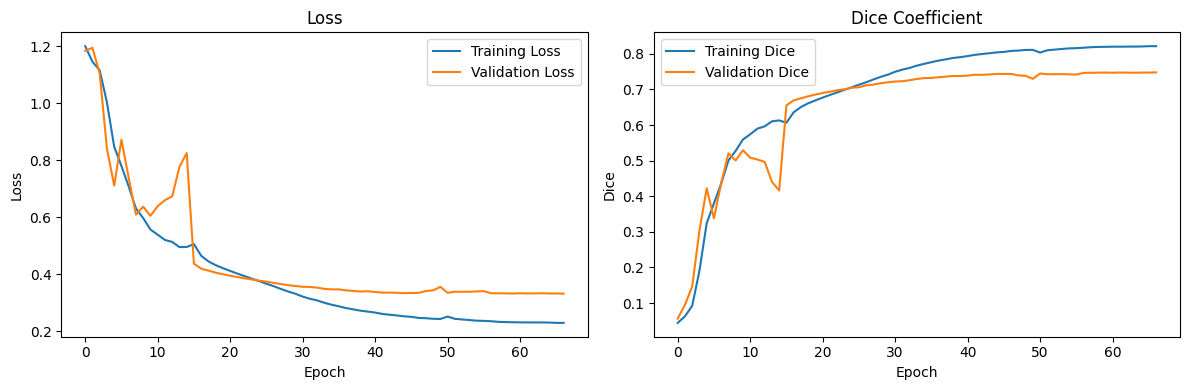

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['dice_coef'], label='Training Dice')
plt.plot(history.history['val_dice_coef'], label='Validation Dice')
plt.title('Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import os

model_path = "/content/drive/MyDrive/best_unet_model.keras"

if os.path.exists(model_path):
    print(" Model file found! Proceeding to load...")
else:
    print(" Model file NOT found! Check the file path.")


 Model file found! Proceeding to load...


In [ ]:
for sample in test_dataset.take(1):
    print("Sample Type:", type(sample))
    print("Sample Length:", len(sample))

    input_tensor, label_tensor = sample
    print("Final Input Shape:", input_tensor.shape)
    print("Final Label Shape:", label_tensor.shape)


Sample Type: <class 'tuple'>
Sample Length: 2
Final Input Shape: (8, 256, 256, 6)
Final Label Shape: (8, 256, 256, 1)


In [ ]:
test_sample = next(iter(test_dataset))
input_tensor, label_tensor = test_sample

predictions = model(input_tensor)
print("Predictions Shape:", predictions.shape)


Predictions Shape: (8, 256, 256, 1)


In [ ]:
model.summary()
print("Expected input shape:", model.input_shape)  #  (None, 256, 256, 6)
print("Expected output shape:", model.output_shape)  (None, 256, 256, 1)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 6)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          3,520 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 32, 32, 512)    │              0 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 512)    │              0 │ dropout[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 16, 16, 1024)   │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 16, 16, 1024)   │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 16, 16, 1024)   │              0 │ conv2d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d        

 Total params: 93,100,421 (355.15 MB)

 Trainable params: 31,033,473 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 62,066,948 (236.77 MB)

Expected input shape: (None, 256, 256, 6)
Expected output shape: (None, 256, 256, 1)


In [ ]:
print("Is compiled?", model.compiled_loss is not None)
print("Loss:", model.loss)
print("Metrics:", model.metrics_names)

Is compiled? True
Loss: <function bce_dice_loss at 0x7e9d74f9fce0>
Metrics: ['loss', 'compile_metrics']


In [ ]:
for img_combined, label in test_dataset.take(1):
    prediction = model(img_combined, training=False)
    print("Prediction shape:", prediction.shape)
    loss_fn = tf.keras.losses.BinaryCrossentropy()
    loss_value = loss_fn(label, prediction)
    print("Manual loss:", loss_value.numpy())
    break

Prediction shape: (8, 256, 256, 1)
Manual loss: 0.104745954


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array


IMG_HEIGHT = 256
IMG_WIDTH = 256

def visualize_predictions(model, a_paths, b_paths, label_paths, indices, num_samples=3, threshold=0.5):
    sample_indices = np.random.choice(indices, num_samples, replace=False)

    plt.figure(figsize=(15, 4 * num_samples))

    for i, idx in enumerate(sample_indices):
        img_a = load_img(a_paths[idx], target_size=(IMG_HEIGHT, IMG_WIDTH))
        img_a = img_to_array(img_a) / 255.0

        img_b = load_img(b_paths[idx], target_size=(IMG_HEIGHT, IMG_WIDTH))
        img_b = img_to_array(img_b) / 255.0

        img_combined = np.concatenate([img_a, img_b], axis=-1)
        img_combined = np.expand_dims(img_combined, axis=0)

        label = load_img(label_paths[idx], target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode='grayscale')
        label = img_to_array(label) / 255.0

        prediction = model.predict(img_combined)[0]

        binary_prediction = (prediction > threshold).astype(np.float32)

        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(img_a)
        plt.title("Image A")
        plt.axis("off")

        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(img_b)
        plt.title("Image B")
        plt.axis("off")

        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(binary_prediction.squeeze(), cmap="gray", vmin=0, vmax=1)
        plt.title("Predicted Change Map (Binary)")
        plt.axis("off")

    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


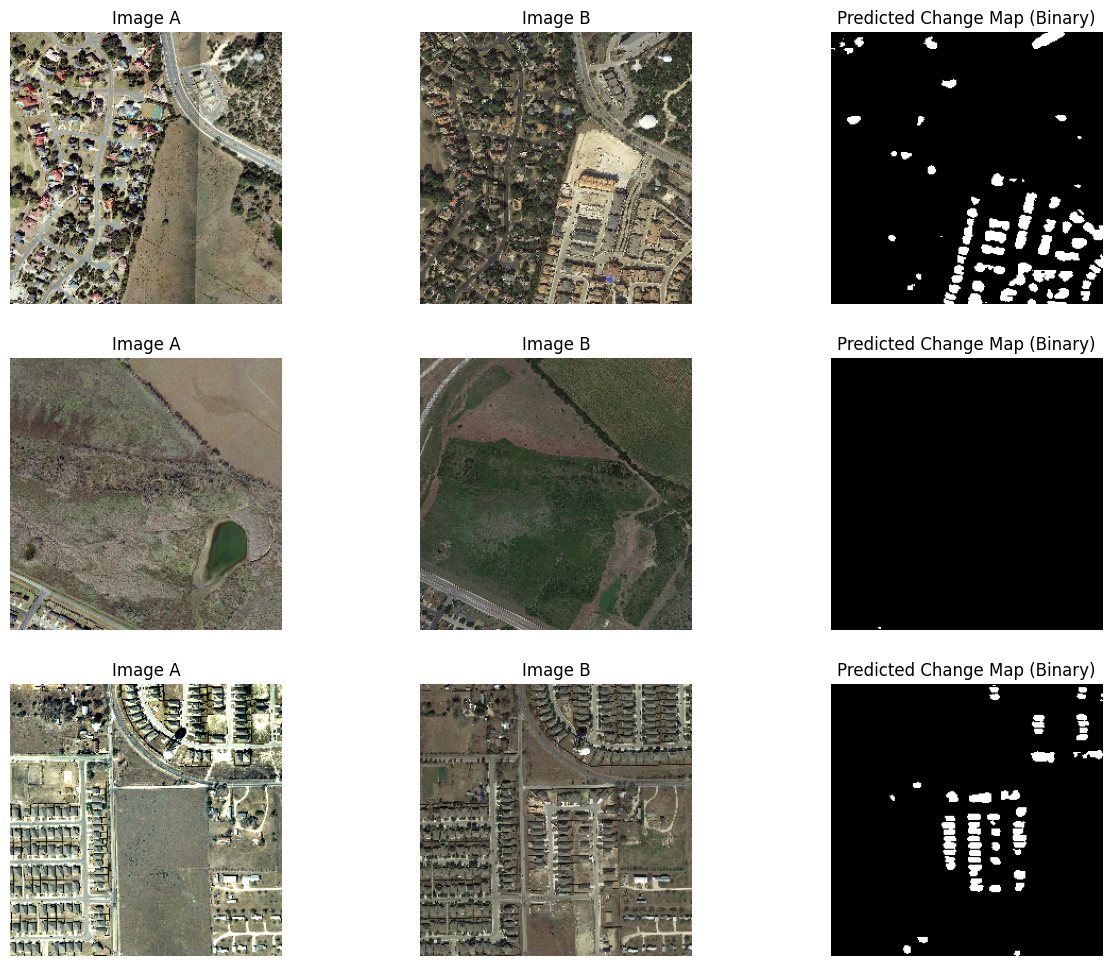

In [ ]:
visualize_predictions(model, a_paths, b_paths, label_paths, indices, num_samples=3, threshold=0.5)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


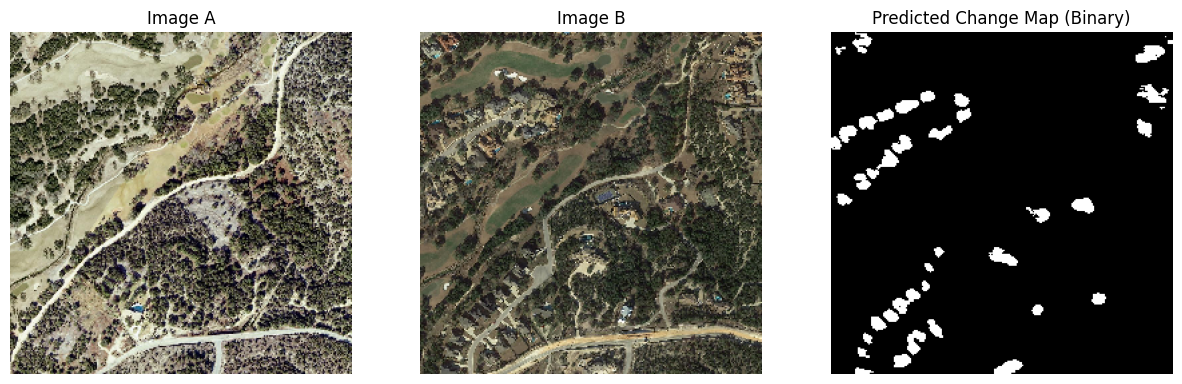

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

IMG_HEIGHT = 256
IMG_WIDTH = 256

def load_and_preprocess_image(image_path):
    img = load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img = img_to_array(img) / 255.0
    return img.astype(np.float32)

image_A_path = "/content/LEVIR-CD/Test/A/test_31.png"
image_B_path = "/content/LEVIR-CD/Test/B/test_31.png"

img_a = load_and_preprocess_image(image_A_path)
img_b = load_and_preprocess_image(image_B_path)

input_image = np.concatenate([img_a, img_b], axis=-1)
input_image = np.expand_dims(input_image, axis=0).astype(np.float32)

prediction = model.predict(input_image)[0]

threshold = 0.5
binary_prediction = (prediction > threshold).astype(np.float32)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Image A")
plt.imshow(img_a)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Image B")
plt.imshow(img_b)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Predicted Change Map (Binary)")
plt.imshow(binary_prediction.squeeze(), cmap="gray", vmin=0, vmax=1)
plt.axis("off")

plt.show()